**Data Science for Business Analytics**

Christina Ho

Nathan Gollogly

**Business Problem**

Regulation of sharing platforms such as AirBnB has been prominent in the news over the past few years. In the summer of 2019, NYC passed strict regulations on the platform. In this project, we are acting as representatives of AirBnB when discussing regulation of the platform with government entities. We would like to show regulators (in an actual dollar amount) how much welfare the platform generates for the market we are operating in. As a subsequent phase of this project, we would seek to estimate the affects of regulation on supply and the calculate Deadweight Loss. Regulation would act like a “tax” on society and would (in theory) decrease consumer surplus.


**Overview**

We used data from AirBnB listings in order to determine Consumer Surplus (or welfare) generated by the platform. As defined on Investopedia: Consumer surplus is an economic measurement of consumer benefits. It's a measure of the additional benefit that consumers receive because they're paying less for something than what they were willing to pay.

 https://www.investopedia.com/terms/c/consumer_surplus.asp

![picture](https://drive.google.com/uc?id=1fq3DUhgN2aB6D5pDPwdMTzoVUxhokjXj)

In [0]:
# importing packages as needed 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import collections
from collections import Counter
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

In [2]:
# this gives permission to google colab to access my google drive

from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


**Obtaining the Data**

The data for this project comes from a third party system that scrapes AirBnB listings, availability, and reviews and consolidates the data into 3 separate files. The data does not include information whether a listing was actually rented or not, however we are able to interpret this by using the presence of a review. http://insideairbnb.com/get-the-data.html

In [3]:
#The raw data files were saved to google drive, here we are reading in the data to dataframes. We use the calendar file from the prior year in order to align availablity with listings and reviews
calendar_df_historic = pd.read_csv("/content/drive/My Drive/Data Science/calendar_historic.csv.gz", compression='gzip')
listings_df = pd.read_csv("/content/drive/My Drive/Data Science/listings.csv.gz", compression='gzip')
reviews_df = pd.read_csv("/content/drive/My Drive/Data Science/reviews.csv.gz", compression='gzip')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (61,62,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


**Data Exploration**

Our first step was just to get a feel for the data in order to determine which features to select. We reviewed histograms of many different features in the listings dataset and chose the ***Borough***, ***Room Type***, and whether the host had been ***Verified*** as our categorical data for modeling. This was because these categorical features were consistently present for each listing (few or no NULLS), and had a distribution that was not over-represented by a single value. We also included the ***Review Score*** as a numerical feature based on our own experience as consumers.

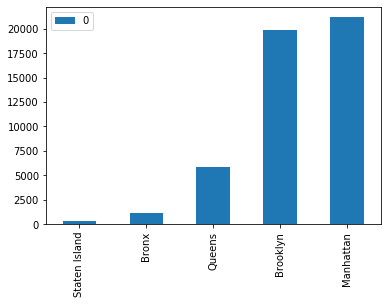

In [6]:
# Plotting Counts of Listings by Borough
nb_counts = Counter(listings_df.neighbourhood_group_cleansed)
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar')

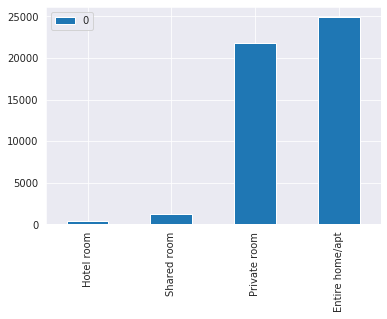

In [23]:
# Plotting Counts of Listings by Room Type
nb_counts = Counter(listings_df.room_type)
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar')

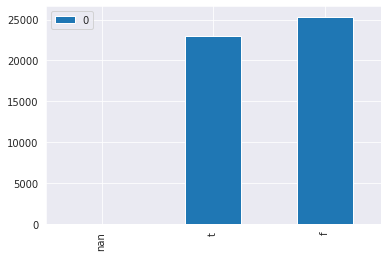

In [24]:
# Plotting Counts of Listings by Room Type
nb_counts = Counter(listings_df.host_identity_verified)
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar')

**Seasonality**

We wanted to understand the impact of seasonality and how it affects price.

In [0]:
calendar_seasonal_available = calendar_df_historic.loc[calendar_df_historic['available'] == 't']
calendar_seasonal = pd.concat((pd.DataFrame(data=calendar_seasonal_available['price'].replace('[\$,]', '', regex=True).astype(float)),pd.to_datetime(calendar_seasonal_available['date'])), axis=1)

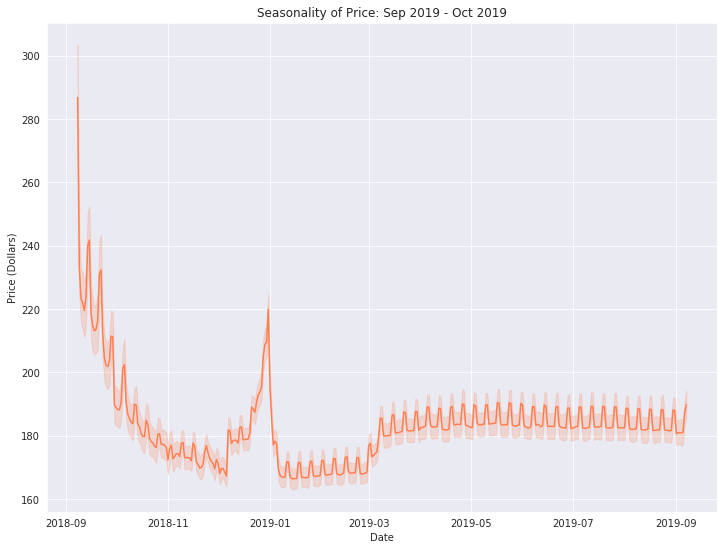

In [22]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(figsize=(12,9))
seasonal_price = sns.lineplot(x=calendar_seasonal.date,y=calendar_seasonal.price,data = calendar_seasonal, color="coral")
seasonal_price.set(xlabel='Date', ylabel='Price (Dollars)')
# seasonal_price.FacetGrid(xticks=np.arange(1,4,1))

seasonal_price.set_title('Seasonality of Price: Sep 2019 - Oct 2019')
plt.show()

A high level of seasonality is evident, with a notable peak over the holiday period. There also appears to be a large peak in September 2018, which is harder to explain (perhaps a result of the data availability). As such, we decided to adjust for seasonality by tracking demand as a percentage of when a listing is available. This was accomplished by calculating a demand percent for each listing (the number of reviews a listing had ÷ days available) over the time period of our analysis (September 2018 - August 2019). This calculation was then annualized (multiplied by 365) to calculate the annual demand in days per listing.


**Feature Selection**

The features chosen below come from the analysis above.

In [0]:
# From the numerous features in each listing, we used the features below to cluster our data
features = [
 'neighbourhood_group_cleansed', 
 'review_scores_rating',
 'room_type',
 'host_identity_verified',
 ]

In [0]:
# The listings data now contains only the features we selected and NULL values have been replaced by 0
listings_df_clean = pd.concat([listings_df[features].fillna(value=0), listings_df['id']], axis=1) 

In [27]:
for col in listings_df_clean.columns: 
    print(col)

neighbourhood_group_cleansed
review_scores_rating
room_type
host_identity_verified
id


In [0]:
# Listing out features and if the values are discrete or continuous for clusering purposes
Features_Dict = {
 'neighbourhood_group_cleansed':'categorical',
 'review_scores_rating':'numeric',
 'room_type':'categorical',
 'host_identity_verified':'categorical',
 }

In [0]:
categorical_data = [key for key,value in Features_Dict.items() if value == 'categorical']

In [30]:
print(categorical_data)

['neighbourhood_group_cleansed', 'room_type', 'host_identity_verified']


In [0]:
# The following 4 lines of code turn our numeric (continuous) variables into binary columns. This is needed to ensure all our data is of a similar type for clustering
listings_df_numeric = pd.get_dummies(listings_df_clean,columns=categorical_data)
listings_df_numeric = listings_df_numeric[listings_df_numeric.review_scores_rating != 0]
listings_df_numeric.loc[listings_df_numeric['review_scores_rating'] < listings_df_numeric['review_scores_rating'].mean(), 'rating_below'] = 1
listings_df_numeric.loc[listings_df_numeric['review_scores_rating'] > listings_df_numeric['review_scores_rating'].mean(), 'rating_above'] = 1

In [0]:
# Our numeric dataframe is now a binary dataframe with no duplicate columns
listings_df_binary = listings_df_numeric.fillna(value=0).drop(columns=['review_scores_rating','host_identity_verified_0'])

In [33]:
listings_df_binary.head()

,id,neighbourhood_group_cleansed_Bronx,neighbourhood_group_cleansed_Brooklyn,neighbourhood_group_cleansed_Manhattan,neighbourhood_group_cleansed_Queens,neighbourhood_group_cleansed_Staten Island,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,host_identity_verified_f,host_identity_verified_t,rating_below,rating_above
1,3831,0,1,0,0,0,1,0,0,0,0,1,1.0,0.0
2,5022,0,0,1,0,0,1,0,0,0,0,1,1.0,0.0
3,5099,0,0,1,0,0,1,0,0,0,1,0,1.0,0.0
4,5121,0,1,0,0,0,0,0,1,0,1,0,1.0,0.0
5,5178,0,0,1,0,0,0,0,1,0,1,0,1.0,0.0


**Clustering**

For our buiness problem, we need to cluster the AirBnB listings into distinct "buckets" in order to hold demand "constant". We want to attribute changes in Quantity Demanded to Price, not because an entire home in Manhattan is more desirable than a shared room in Queens. One cannot compare those listings to each other directly, so our listing echelons will help us accurately compare similar products to each other, in order to see the affect of Price.

We used kmodes clustering because we cannot measure Euclidean distance as in kmeans. Instead, we are using a frequency based approach to cluster our categorical data.

We tried several different numbers of clusters, but settled on 6 as it returned results that we felt fit into distinct groups of listings.



In [36]:
pip install kmodes

In [0]:
# the data for kmodes clusering are all our features in our binary listing dataframe
data = listings_df_binary.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12,13]].values

In [37]:
import numpy as np
from kmodes.kmodes import KModes

km = KModes(n_clusters=6, init='Huang', n_init=5, verbose=1)

clusters = km.fit_predict(data)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5820, cost: 49183.0
Run 1, iteration: 2/100, moves: 5482, cost: 49183.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 11163, cost: 51604.0
Run 2, iteration: 2/100, moves: 330, cost: 51604.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 9471, cost: 62076.0
Run 3, iteration: 2/100, moves: 0, cost: 62076.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 4285, cost: 53290.0
Run 4, iteration: 2/100, moves: 164, cost: 53290.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 3612, cost: 55267.0
Run 5, iteration: 2/100, moves: 5006, cost: 54270.0
Run 5, iteration: 3/100, moves: 2750, cost: 52046.0
Run 5, iteration: 4/100, moves: 

In [38]:
clusters.max()

5

In [0]:
# Now that we have our clusters, we need to convert our binary dataframe (which is hard for humans to read) back into a dataframe we can easily interpret
ListingClusters = pd.DataFrame(clusters, index=listings_df_binary['id']).reset_index()
ListingClusters.columns=['id','cluster']
ListingClusters = ListingClusters.sort_values('cluster')
ListingClusters = ListingClusters.merge(listings_df_clean, left_on='id', right_on='id')

In [0]:
# We are assigning each cluster to its own dataframe
cluster_0 = ListingClusters.loc[ListingClusters['cluster'] == 0]
cluster_1 = ListingClusters.loc[ListingClusters['cluster'] == 1]
cluster_2 = ListingClusters.loc[ListingClusters['cluster'] == 2]
cluster_3 = ListingClusters.loc[ListingClusters['cluster'] == 3]
cluster_4 = ListingClusters.loc[ListingClusters['cluster'] == 4]
cluster_5 = ListingClusters.loc[ListingClusters['cluster'] == 5]

Our first cluser (cluster_0) are listings in all boroughs with higher than average review scores, consisting primarily of the entire apartment/home, but where the host has not been verified. We have interpreted this cluster to be our **Value (All Boroughs)** listings. That is, the location is not always ideal, and the host has not been verified, but the reviews for these listings are good.

In [41]:
cluster_0.head()

,id,cluster,neighbourhood_group_cleansed,review_scores_rating,room_type,host_identity_verified
0,19553123,0,Queens,98.0,Entire home/apt,f
1,21799291,0,Manhattan,100.0,Entire home/apt,f
2,21800445,0,Manhattan,97.0,Entire home/apt,f
3,21802239,0,Manhattan,95.0,Entire home/apt,f
4,21804600,0,Brooklyn,96.0,Entire home/apt,f


cluster_1 is also all boroughs with higher than average ratings, but where the host has not been verified. The difference from cluster_0 is that these listings are all private rooms. This segment we are calling **Value Shared (All Boroughs)** as a traveler will be sharing an apartment with a host, but will have a private room.

In [42]:
cluster_1.head()

,id,cluster,neighbourhood_group_cleansed,review_scores_rating,room_type,host_identity_verified
6433,12713289,1,Brooklyn,100.0,Private room,f
6434,19789620,1,Bronx,98.0,Private room,f
6435,32717623,1,Queens,93.0,Private room,f
6436,1870228,1,Queens,89.0,Private room,f
6437,12713995,1,Queens,88.0,Private room,f


cluster_2 is a mixed bag of below average ratings, primarily a single room in a shared apartment, with the host often not verified. This is our **Budget (All Boroughs)** cluster for small groups/individual travelers.

In [43]:
cluster_2.head()

,id,cluster,neighbourhood_group_cleansed,review_scores_rating,room_type,host_identity_verified
14115,29157211,2,Queens,81.0,Entire home/apt,f
14116,23876337,2,Manhattan,90.0,Entire home/apt,t
14117,17079313,2,Manhattan,85.0,Private room,f
14118,26816742,2,Manhattan,73.0,Shared room,f
14119,21124150,2,Queens,93.0,Entire home/apt,f


cluster_3 is **Premium (All Boroughs)**. With the listings almost all for the entire home, above average ratings, and host identity verified.

In [44]:
cluster_3.head()

,id,cluster,neighbourhood_group_cleansed,review_scores_rating,room_type,host_identity_verified
20724,289037,3,Brooklyn,100.0,Entire home/apt,t
20725,289665,3,Manhattan,96.0,Entire home/apt,t
20726,36346168,3,Brooklyn,100.0,Entire home/apt,t
20727,145064,3,Brooklyn,94.0,Entire home/apt,t
20728,197155,3,Manhattan,94.0,Entire home/apt,t


cluster_4 is **Premium Shared (excl Brooklyn)**. High reviews and hosts verified, but these rooms are all in apartments shared with the tenants of the apartment.

In [45]:
cluster_4.head()

,id,cluster,neighbourhood_group_cleansed,review_scores_rating,room_type,host_identity_verified
29513,17665996,4,Queens,97.0,Private room,t
29514,7689346,4,Manhattan,100.0,Private room,t
29515,1702581,4,Manhattan,91.0,Private room,t
29516,33094622,4,Queens,90.0,Private room,t
29517,29079742,4,Manhattan,90.0,Private room,t


cluster_5 is our **Budget (Brooklyn)** with below average ratings and listings for single rooms in shared apartments

In [46]:
cluster_5.head()

,id,cluster,neighbourhood_group_cleansed,review_scores_rating,room_type,host_identity_verified
33738,8635964,5,Brooklyn,80.0,Private room,t
33739,7132891,5,Brooklyn,95.0,Private room,t
33740,193333,5,Brooklyn,88.0,Private room,t
33741,7020266,5,Brooklyn,96.0,Private room,t
33742,5803,5,Brooklyn,94.0,Private room,t


In [67]:
# Code used to evalate clusters
cluster_5.room_type.unique()

array(['Private room'], dtype=object)

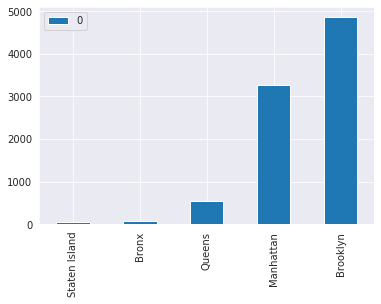

In [98]:
# Code used to plot histograms of cluster features
nb_counts = Counter(cluster_3.neighbourhood_group_cleansed)
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar')

**Price and Quantity Demanded**

The real challenge of our business scenario is to estimate consumer surplus. In order to do this, what we need is Price and Quantity Demanded.

In [0]:
# We need to have a similar starting point for reviews (a listing that has been up for 5 years will clearly have more reviews, so we are only considering reviews that occured during the availability from our calendar file)
reviews_df_filtered = reviews_df.loc[reviews_df['date'] > calendar_df_historic['date'].min()] 

In [0]:
# To adjust for seasonality and availability, looking at availability data
availability_df = calendar_df_historic.loc[calendar_df_historic['available'] == 't'].groupby(['listing_id']).agg(['count'])
availability_df = availability_df.drop(columns=[(     'date', 'count'),(    'price', 'count')])

In [0]:
# Quantity demanded is approximately equal to the number of reviews (or at least we are taking a leap of faith to say these are correlated). This code isolates quantity demanded from our reviews df.
quantity_demanded = reviews_df_filtered.groupby(['listing_id']).agg(['count'])
quantity_demanded = quantity_demanded.drop(columns=['date','reviewer_id','reviewer_name','comments'])
quantity_demanded = availability_df.merge(quantity_demanded, left_on='listing_id', right_on='listing_id')
quantity_demanded = pd.DataFrame(data=quantity_demanded[('id', 'count')]/quantity_demanded[('available', 'count')],columns=['demand_pct'])
quantity_demanded = quantity_demanded[quantity_demanded.demand_pct <= 1]
quantity_demanded = quantity_demanded.mul(365)

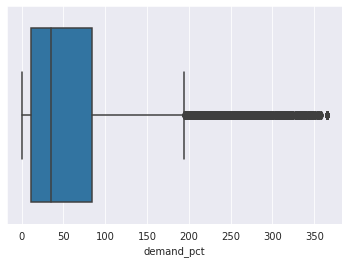

In [72]:
#box plot for quant demanded, as you can see, most have few reviews
sns.boxplot(x=quantity_demanded[('demand_pct')])

In [0]:
# Data cleanup needed to convert the datatype price (with a $ sign) into a float for analysis
price_float = pd.DataFrame(data=listings_df['price'].replace('[\$,]', '', regex=True).astype(float))
price_float = price_float.rename(columns={'price':"float_price"})

We removed outliers from the dataset. As one can see from the boxplot, there is a long tail in terms of high outlying prices for listings. Once the outliers were removed, the second boxplot shows a much more even distribution.

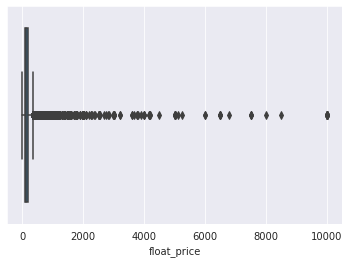

In [74]:
sns.boxplot(x=price_float[('float_price')])

In [75]:
#Finding the inter quartile range
Q1 = price_float.quantile(0.25)
Q3 = price_float.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

float_price    106.0
dtype: float64


In [76]:
#shape before
price_float.shape

(48377, 1)

In [77]:
# shape after removing outliers
price_float_out = price_float[~((price_float < (Q1 - 1.5 * IQR)) |(price_float> (Q3 + 1.5 * IQR))).any(axis=1)]
price_float_out.shape

(45502, 1)

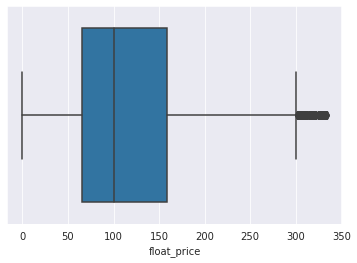

In [78]:
sns.boxplot(x=price_float_out['float_price'])

In [0]:
price = pd.concat((price_float_out,listings_df), axis=1)
price = price[['id','float_price']]

In [0]:
#Merging price and quantity together
pq_df = price.merge(quantity_demanded, left_on='id', right_on='listing_id')

In [0]:
# Assigning price and quantity to our clusters
cluster_0_pq = pq_df.merge(cluster_0, left_on='id', right_on='id')
cluster_1_pq = pq_df.merge(cluster_1, left_on='id', right_on='id')
cluster_2_pq = pq_df.merge(cluster_2, left_on='id', right_on='id')
cluster_3_pq = pq_df.merge(cluster_3, left_on='id', right_on='id')
cluster_4_pq = pq_df.merge(cluster_4, left_on='id', right_on='id')
cluster_5_pq = pq_df.merge(cluster_5, left_on='id', right_on='id')

In [0]:
all_clusters = pq_df.merge(ListingClusters, left_on='id', right_on='id')

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


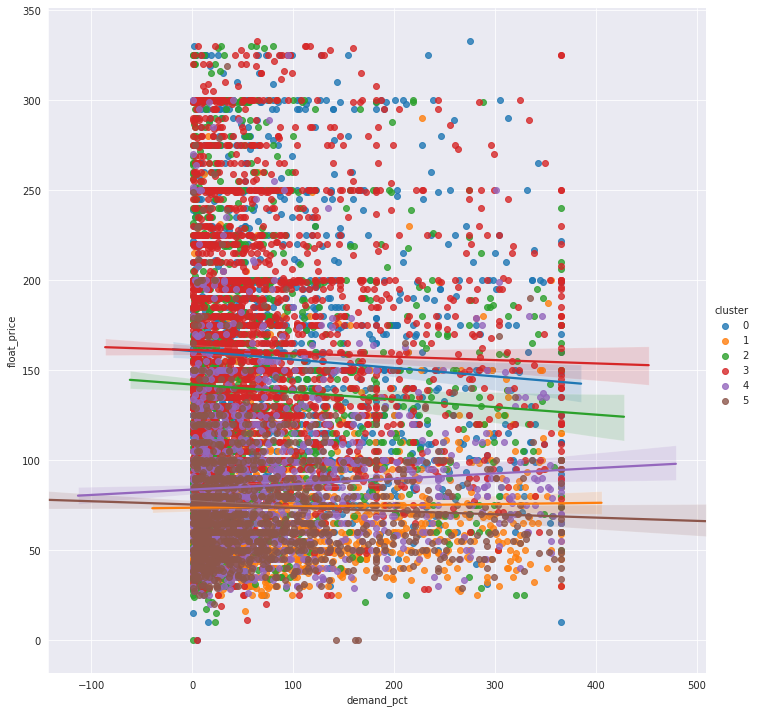

In [83]:
sns.lmplot(x='demand_pct',y='float_price',data=all_clusters,hue="cluster",fit_reg=True,size=10) 

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


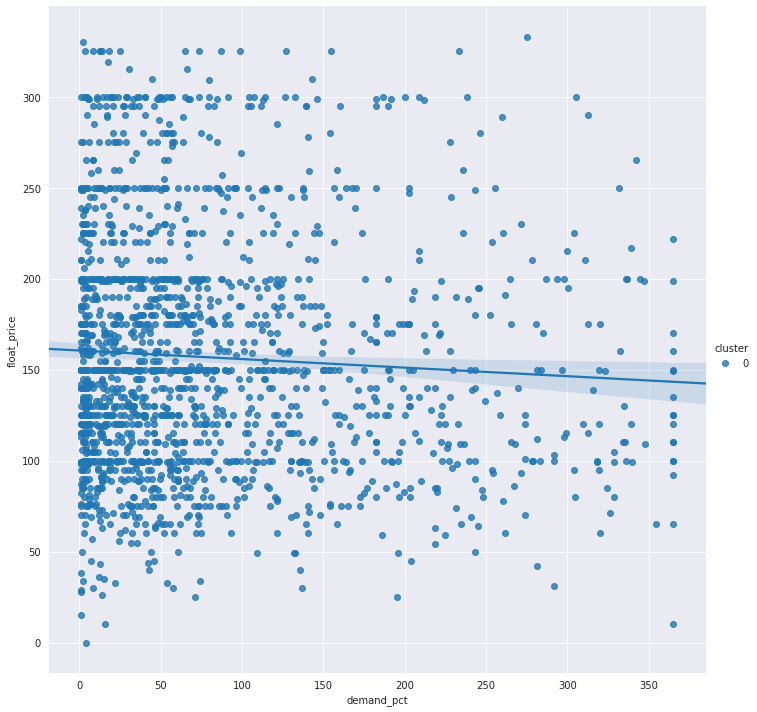

In [85]:
sns.lmplot(x='demand_pct',y='float_price',data=cluster_0_pq,hue="cluster",fit_reg=True,size=10) 

In [0]:
#get the values for any given cluster
def cluster_stats(cluster_name):
  cluster = cluster_name
  x = cluster.fillna((cluster['demand_pct'].mean()), inplace=True)
  y = cluster.fillna((cluster['float_price'].mean()), inplace=True)
  x = cluster['demand_pct']
  y = cluster['float_price']
  slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
  print("Slope: ",slope,"\n"
        ," Intercept: ", intercept,"\n"
        ," r_value: ", r_value,"\n"
        ," r_squared: ", r_value*r_value,"\n"
        ," p_value: ", p_value,"\n"
        ," std_err: ", std_err)


In [104]:
cluster_stats(cluster_0_pq)

Slope:  -0.026914792571857186 
  Intercept:  151.61081842494968 
  r_value:  -0.03398633793822201 
  r_squared:  0.0011550711664510289 
  p_value:  0.13344553308964954 
  std_err:  0.017927914842616112


In [0]:
#get the consumer surplus of any given cluster
def cluster_cs(cluster_name):
  cluster = cluster_name
  avg_price = cluster['float_price'].mean()
  x = cluster.fillna((cluster['demand_pct'].mean()), inplace=True)
  y = cluster.fillna((cluster['float_price'].mean()), inplace=True)
  x = cluster['demand_pct']
  y = cluster['float_price']
  slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
  height = intercept - avg_price
  base = height/(slope*-1)
  consumer_surplus = (base*height)/2
  print("Consumer Surplus: ",consumer_surplus)

In [91]:
 cluster_cs(cluster_0_pq)

Consumer Surplus:  79.20001131995099


**Evaluation of Results**

Our graphs and analysis were not what we were expecting. Our "best" cluster (the cluster with the steepest demand slope) had a very gradual downward slope of -0.03 and an R-sq value of 0.0011. This says that less than 1% of the variance in the dependent variable (Quantity Demanded) can be explained by a change in the independent variable (Price). Essentially, there is next to no correlation between Price and Quantity Demanded in this market.